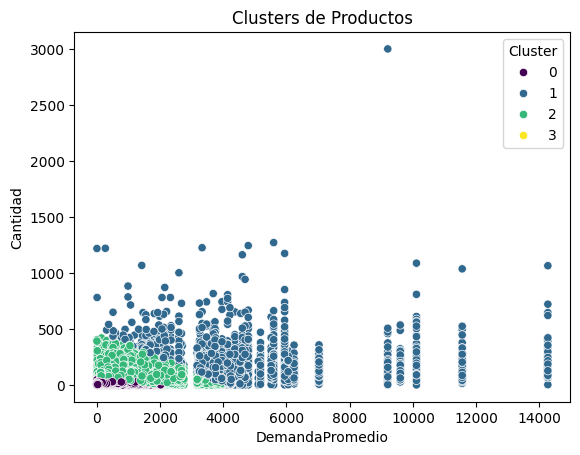

   Cluster  DemandaPromedio    Cantidad       Precio
0        0       231.617520   13.381356    23.956919
1        1      5071.827298  161.782963    10.628453
2        2      1174.084378   79.795606    12.345117
3        3         1.000000    1.274510  4052.811765


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Cargar datos
ventas = pd.read_csv("Ventas.csv")
inventario = pd.read_csv("InventarioFinal.csv")
detalle_compras = pd.read_csv("DetalleCompra.csv")

# Preprocesamiento
ventas['FechaVenta'] = pd.to_datetime(ventas['FechaVenta'])
ventas['Mes'] = ventas['FechaVenta'].dt.to_period('M')
ventas_agg = ventas.groupby(['ProductoId', 'Mes']).agg({'CantidadVendida': 'sum'}).reset_index()

# Calcular demanda promedio mensual por producto
demanda_promedio = ventas_agg.groupby('ProductoId')['CantidadVendida'].mean().reset_index()
demanda_promedio.columns = ['ProductoId', 'DemandaPromedio']

# Unir con inventario actual
inventario = inventario.merge(demanda_promedio, on='ProductoId', how='left')
inventario['DiasStock'] = inventario['Cantidad'] / inventario['DemandaPromedio'] * 30

# Se puede incluir características como 'DemandaPromedio', 'Cantidad', 'VentasHistoricas', etc.
features = inventario[['DemandaPromedio', 'Cantidad', 'Precio']]  # Se puede agregar más variables
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')  # Otras opciones son 'median' o 'most_frequent'
features_imputed = imputer.fit_transform(features)

features_scaled = scaler.fit_transform(features_imputed)

# Aplicar K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Elige el número de clusters
inventario['Cluster'] = kmeans.fit_predict(features_scaled)

# Visualización de los clusters
sns.scatterplot(x=inventario['DemandaPromedio'], y=inventario['Cantidad'], hue=inventario['Cluster'], palette='viridis')
plt.title("Clusters de Productos")
plt.show()

# Analizar los clusters
cluster_summary = inventario.groupby('Cluster').agg({
    'DemandaPromedio': 'mean',
    'Cantidad': 'mean',
    'Precio': 'mean'
}).reset_index()
print(cluster_summary)


**RESULTADOS**<br>
Cluster 0:<br>
Promedio de Demanda: 231.62
Promedio de Cantidad: 13.38
Promedio de Precio: 23.96<br>
<br>
Interpretación:<br>
Los puntos del Cluster 0 están todos en la esquina inferior izquierda del gráfico, lo que indica que estos productos tienen una baja demanda promedio (231.62) y una baja cantidad en inventario (13.38), pero un precio relativamente alto (23.96).
Esto sugiere que estos productos podrían ser artículos de baja rotación o productos con precios altos, lo que podría significar que no se venden tan rápido o que tienen una menor cantidad disponible en el inventario.


Cluster 1:<br>
Promedio de Demanda: 5071.83
Promedio de Cantidad: 161.78
Promedio de Precio: 10.63<br>
<br>
Interpretación:<br>
Este grupo tiene productos con una demanda promedio mucho más alta que los del Cluster 0 (5071.83 frente a 231.62), y también tienen una cantidad promedio más alta (161.78 frente a 13.38).
El precio es más bajo en promedio (10.63 frente a 23.96), lo que podría indicar que son productos más asequibles o de mayor rotación.
Los puntos del Cluster 1 están dispersos por varias zonas, pero en su mayoría están más cerca del eje X (baja cantidad), lo que podría indicar que, a pesar de su alta demanda, los productos en este grupo podrían estar con stock bajo en ciertos momentos o con un nivel de stock variable. El patrón que describe en líneas verticales podría representar reordenes o niveles de stock que se repiten en ciertos valores (como 6000, 7000, 11000, 14000), lo que sugiere una posible periodicidad en la oferta o reposición de estos productos.

Cluster 2:<br>
Promedio de Demanda: 1174.08
Promedio de Cantidad: 79.80
Promedio de Precio: 12.35<br>
<br>
Interpretación:<br>
Los puntos del Cluster 2 forman un triángulo rectángulo, lo que sugiere que los productos en este grupo tienen una demanda moderada (1174.08), cantidad promedio moderada (79.80), y un precio intermedio (12.35).
Este patrón podría indicar que estos productos tienen una relación proporcional entre su cantidad y demanda (un aumento en la demanda con un aumento en la cantidad), pero no tan pronunciada como en el Cluster 1.

**Resumen:**<br>
Cluster 0: Productos de baja rotación y precios altos, con inventarios limitados.<br>
Cluster 1: Productos de alta demanda, con precios más bajos y una mayor cantidad en stock, probablemente de alta rotación.<br>
Cluster 2: Productos con demanda y cantidad moderadas, con un precio intermedio. Tienen un patrón proporcional en cuanto a cantidad y demanda.<br>
Cluster 3: Productos con demanda extremadamente baja y precios muy altos, posiblemente artículos de lujo o de nicho.<br>

**Sugerencias:**<br>
Para los productos en Cluster 1, podría ser útil optimizar los niveles de stock y asegurarse de que estén disponibles en grandes cantidades para satisfacer la alta demanda.<br>
Los productos en Cluster 0 podrían beneficiarse de una revisión de precios o una estrategia de marketing para aumentar la rotación de stock.<br>
Los productos del Cluster 3 parecen estar en una categoría muy especial, por lo que tal vez se deba revisar si se justifica su bajo volumen de ventas o si existe una estrategia de precios de alto valor que se pueda mantener. O revisar en las tiendas donde se han vendido o que están ubicadas en zonas exclusivas de la cuidad y reubicar allí estos productos. <br>
Cluster 2 parece tener una demanda estable, por lo que mantener un inventario equilibrado podría ser clave.

**RESUMEN DE ASIGNACION DE CLUSTER A CADA PRODUCTO**

In [5]:
# Agregar el nombre del producto a los resultados de clustering
inventario_cluster = inventario[['ProductoId', 'NombreProducto', 'Cluster']]  # Asegúrate de que 'NombreProducto' esté en el DataFrame
inventario_cluster['Cluster'] = inventario['Cluster']

# Verifica los primeros registros
print(inventario_cluster.head())

# Exportar a CSV
inventario_cluster.to_csv("Productos_Con_Cluster.csv", index=False)

# Mostrar el resumen de los productos por cluster
cluster_summary = inventario_cluster.groupby('Cluster').agg({'ProductoId': 'count'}).reset_index()
cluster_summary.columns = ['Cluster', 'NumeroDeProductos']
print('')
print(cluster_summary)

C:\Users\mariu\AppData\Local\Temp\ipykernel_1364\3884992774.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inventario_cluster['Cluster'] = inventario['Cluster']


   ProductoId               NombreProducto  Cluster
0          58  Gekkeikan Black & Gold Sake        0
1          62     Herradura Silver Tequila        0
2          63   Herradura Reposado Tequila        0
3          72         No. 3 London Dry Gin        0
4          75    Three Olives Tomato Vodka        0

   Cluster  NumeroDeProductos
0        0             200036
1        1               3193
2        2              21209
3        3                 51


In [8]:
inventario_cluster.sample(12)

,ProductoId,NombreProducto,Cluster
74756,10609,Oyster Bay Chard Marlboro,0
167625,7985,Noilly Prat Extra Dry Vermou,0
170733,14672,Duckhorn Decoy Cab Svgn,0
70078,22757,Black Opal Cshmre Cab/Merlot,0
12168,8264,Ch Ste Michelle Rsl,0
143305,29081,Beringer Wh Znfdl/Chard LVS,0
186891,35464,Stags Leap WC Artemis Cab,2
18880,31320,La Vieille Ferme Rose Vntoux,0
219411,17867,Beringer Classic Wh Zin Mosc,0
25066,29212,R Mondavi Merlot Pvt Sel,0


Usamos StandardScaler para la optimización porque el algoritmo de clustering K-Means (y otros modelos de machine learning) son sensibles a la escala de los datos.<br>

📌 Razones clave para usar StandardScaler:<br>
1️⃣ K-Means usa distancias euclidianas:<br>

K-Means agrupa los datos basándose en la distancia entre puntos en un espacio multidimensional.
Si una variable tiene valores mucho más grandes que otra, dominará el cálculo de la distancia y afectará los clusters.<br>
<br>
2️⃣ Diferentes escalas en las variables:<br>
En nuestro caso, DemandaPromedio, Cantidad y Precio tienen rangos muy diferentes:
DemandaPromedio puede estar en cientos o miles.
Cantidad es menor pero aún variable.
Precio puede ser bajo pero con valores extremos en algunos productos.
Sin escalado, K-Means daría más peso a las variables con valores más grandes.<br>
<br>
3️⃣ StandardScaler estandariza los datos:<br>
Transforma cada variable para que tenga media = 0 y desviación estándar = 1.
Esto hace que todas las variables contribuyan de manera equitativa al clustering.
